In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
import corner

In [5]:
import radvel

In [6]:
#We first get the data of Kepler 12b.
data = pd.read_csv('../../data/lcdata/KEPLER12b.txt', sep='	')

data

t      flux
0    663.485535  1.000537
1    663.486216  0.999304
2    663.486897  0.999957
3    663.487578  1.000257
4    663.488259  0.999216
..          ...       ...
446  663.780451  1.000140
447  663.781132  0.999546
448  663.781813  1.000699
449  663.782494  0.999274
450  663.783175  0.999264

[451 rows x 2 columns]

In [7]:
#We define the time and flux as arrays. (Assuming errors are zero)
t = data.t.values
flux = data.flux.values
flux_err = np.zeros(len(flux))

In [8]:
#Now we import the GaiaRV source codes.
import sys
sys.path.insert(0, '../../gaiafit/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import utils.py, gaiafit.py, gaiasource.py as follows.
import utils
import gaiafitwithtransit
import gaiasource
reload(gaiafitwithtransit)

gaiafitwithtransit, gaiasource, utils

list.remove(x): x not in list


(<module 'gaiafitwithtransit' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/gaiafitwithtransit.py'>,
 <module 'gaiasource' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/gaiasource.py'>,
 <module 'utils' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/utils.py'>)

In [9]:
#We load the Prior file for our target.
f = '../../data/lcpriors/kepler12b_prior.txt'
reload(gaiafitwithtransit)

<module 'gaiafitwithtransit' from '/home/kayahan/ExoSoft/notebooks/lc-tests/../../gaiafit/gaiafitwithtransit.py'>

In [10]:
#We then use "LPFunctionRVOnly2" from the "gaiafit.py" code to do the fitting.
    #LPFunction => Likelihood Function
    #RVOnly => Tells you that it is only doing RV analysis, not Gaia Astrometric Analysis.

#Note that LPFunctionRVOnly plots the Priors.
L = gaiafitwithtransit.LPFunctionTransit(t,flux,flux_err,file_priors=f)

#We do a Gaia Fit for RV Only as follows. (Needs the Likelihood Function to work)
TF = gaiafitwithtransit.RMFit(L)

Reading in priorfile from ../../data/lcpriors/kepler12b_prior.txt
   prior          arg1        arg2     label description priortype  fixed
0     NP  4.437963e+00    0.000060      P_p1        P_p1     model  False
1     NP  8.019000e+00    0.014000      a_p1        a_p1     model  False
2     NP  2.455004e+06    0.000010     t0_p1       t0_p1     model  False
3     UP  0.000000e+00    0.010000    ecc_p1      ecc_p1     model  False
4     UP  0.000000e+00  360.000000  omega_p1    omega_p1     model  False
5     NP  1.680000e-01    0.010000      b_p1        b_p1     model  False
6     NP  1.188670e-01    0.000094      p_p1        p_p1     model  False
7     NP  4.701040e+00    0.000920   tdur_p1     tdur_p1     model  False
8     UP  1.000000e-01    0.500000        u1          u1     model  False
9     UP  1.000000e-01    0.500000        u2          u2     model  False
10    UP -1.000000e-01    0.100000     gamma       gamma     model  False
11    FP  2.000000e-02    0.020000   exptime  

In [11]:
#We do the Minimization using PyDE as follows.
#Note that the Minimization includes the MCMC i.e. the Parameter Space exploration.
TF.minimize_PyDE(de_iter=200,mc_iter=2000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv   center_dist
0       P_p1  4.437963e+00  4.437663e+00  4.438263e+00  4.437962e+00  9.010483e-07
1       a_p1  8.019000e+00  7.949000e+00  8.089000e+00  8.019249e+00 -2.490592e-04
2      t0_p1  2.455004e+06  2.455004e+06  2.455004e+06  2.455004e+06  2.430752e-07
3     ecc_p1  5.000000e-03  0.000000e+00  1.000000e-02  3.721365e-04  4.627863e-03
4   omega_p1  1.800000e+02  0.000000e+00  3.600000e+02  1.858663e+02 -5.866312e+00
5       b_p1  1.680000e-01  1.180000e-01  2.180000e-01  1.680415e-01 -4.153061e-05
6       p_p1  1.188670e-01  1.183970e-01  1.193370e-01  1.188673e-01 -2.559946e-07
7    tdur_p1  4.701040e+00  4.696440e+00  4.705640e+00  4.701043e+00 -2.547989e-06
8         u1  3.000000e-01  1.000000e-01  5.000000e-01  1.877961e-01  1.122039e-01
9         u2  3.000000e-01  1.000000e-01  5.000000e-01  2.800139e-01  1.998615e-02
10     gamma  0.000000e+0

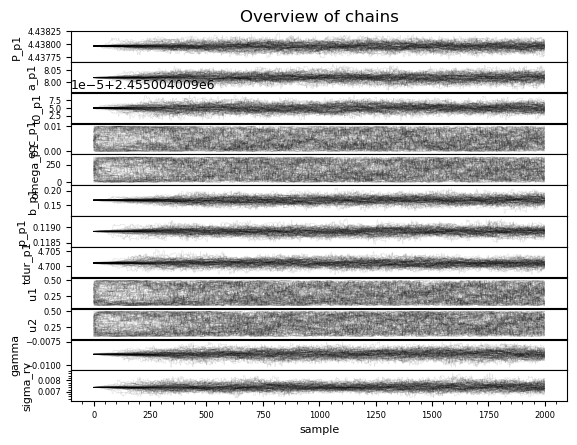

In [12]:
#We import mcmc_help.
import mcmc_help

#We use the plot_chains function to plot the chains as follows.
mcmc_help.plot_chains(TF.sampler.chain,labels=TF.lpf.ps_vary.labels)

plt.show();

In [13]:
#We define the burn in index to be 1000.
#This means that the first 1000 samples per chain will be ignored.
burnin_index = 1000

#We extract the chains after the burn in phase.
    #First part: We take all the chains.
    #Second part: We ignore the first 1000 samples per chain. (hence "burnin_index")
    #Third part: We take all the parameters.
chains_after_burnin = TF.sampler.chain[:,burnin_index:,:]

#We then flatten the chains as follows.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#To store the posteriors we have obtained from the chains, we define a Pandas DataFrame as follows.
df_post = pd.DataFrame(flatchain,columns=TF.lpf.ps_vary.labels)

df_post

P_p1      a_p1         t0_p1    ecc_p1    omega_p1      b_p1  \
0      4.43796  8.024923  2.455004e+06  0.000671   81.949444  0.167199   
1      4.43797  8.028342  2.455004e+06  0.000366   66.701733  0.166623   
2      4.43797  8.028342  2.455004e+06  0.000366   66.701733  0.166623   
3      4.43797  8.028342  2.455004e+06  0.000366   66.701733  0.166623   
4      4.43797  8.028342  2.455004e+06  0.000366   66.701733  0.166623   
...        ...       ...           ...       ...         ...       ...   
99995  4.43799  8.030993  2.455004e+06  0.000468  170.370836  0.163904   
99996  4.43799  8.030993  2.455004e+06  0.000468  170.370836  0.163904   
99997  4.43799  8.030993  2.455004e+06  0.000468  170.370836  0.163904   
99998  4.43799  8.030993  2.455004e+06  0.000468  170.370836  0.163904   
99999  4.43799  8.030993  2.455004e+06  0.000468  170.370836  0.163904   

           p_p1   tdur_p1        u1        u2     gamma  sigma_rv  
0      0.118717  4.701000  0.377731  0.331477 -0.008282  0.007543  
1      0.118706  4.701429  0.367685  0.400023 -0.008085  0.007679  
2      0.118706  4.701429  0.367685  0.400023 -0.008085  0.007679  
3      0.118706  4.701429  0.367685  0.400023 -0.008085  0.007679  
4      0.118706  4.701429  0.367685  0.400023 -0.008085  0.007679  
...         ...       ...       ...       ...       ...       ...  
99995  0.119047  4.702938  0.415825  0.365590 -0.008817  0.007307  
99996  0.119047  4.702938  0.415825  0.365590 -0.008817  0.007307  
99997  0.119047  4.702938  0.415825  0.365590 -0.008817  0.007307  
99998  0.119047  4.702938  0.415825  0.365590 -0.008817  0.007307  
99999  0.119047  4.702938  0.415825  0.365590 -0.008817  0.007307  

[100000 rows x 12 columns]

In [14]:
#We print out the median values as follows.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)
df_medvals[['Labels','values']]

Labels                                  values
0      P_p1        $4.437957_{-0.00006}^{+0.00006}$
0      a_p1               $8.019_{-0.014}^{+0.013}$
0     t0_p1  $2455004.009151_{-0.00001}^{+0.00001}$
0    ecc_p1            $0.0043_{-0.0029}^{+0.0037}$
0  omega_p1               $170.0_{-120.0}^{+130.0}$
0      b_p1            $0.1684_{-0.0096}^{+0.0100}$
0      p_p1        $0.118871_{-0.00009}^{+0.00009}$
0   tdur_p1         $4.70095_{-0.00092}^{+0.00095}$
0        u1                  $0.28_{-0.12}^{+0.13}$
0        u2                  $0.31_{-0.14}^{+0.13}$
0     gamma        $-0.00881_{-0.00036}^{+0.00035}$
0  sigma_rv         $0.00742_{-0.00024}^{+0.00026}$

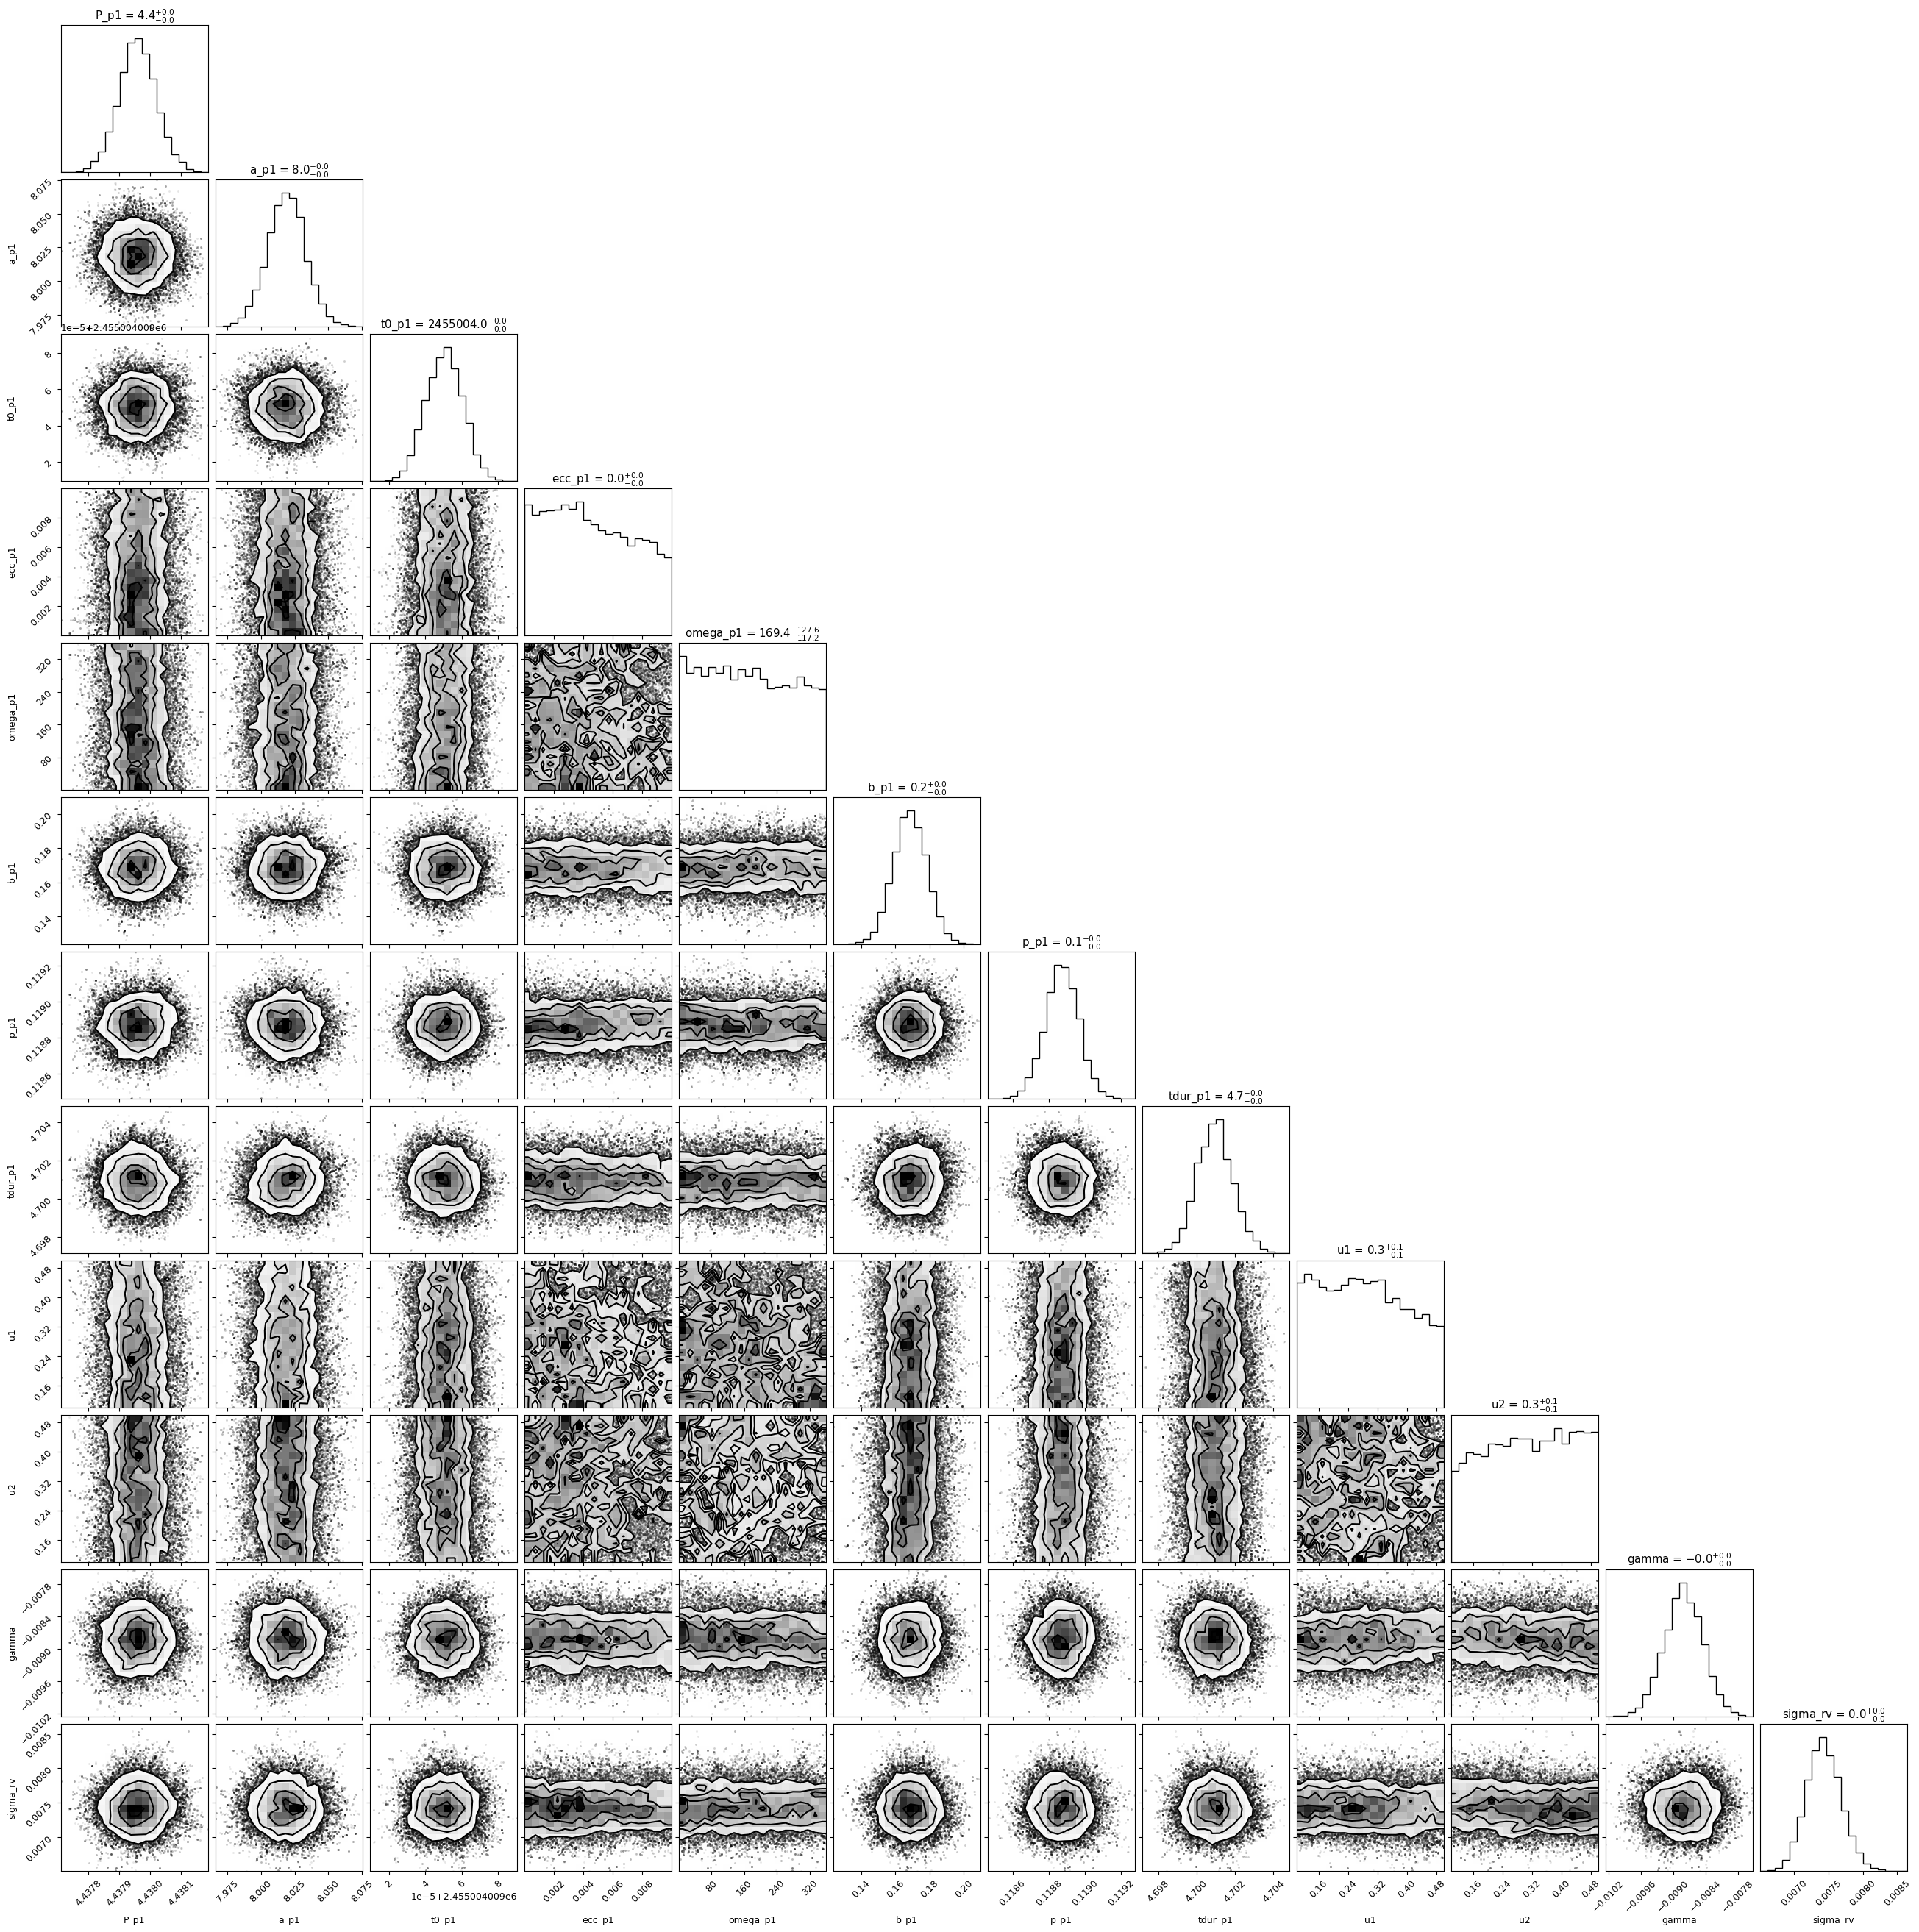

In [15]:
#We then plot the Corner Plot.
import corner
corner.corner(df_post.values,
       show_titles=True,labels=list(df_post.columns),title_fmt='.1f',xlabcord=(0.5, -0.2));

plt.show();

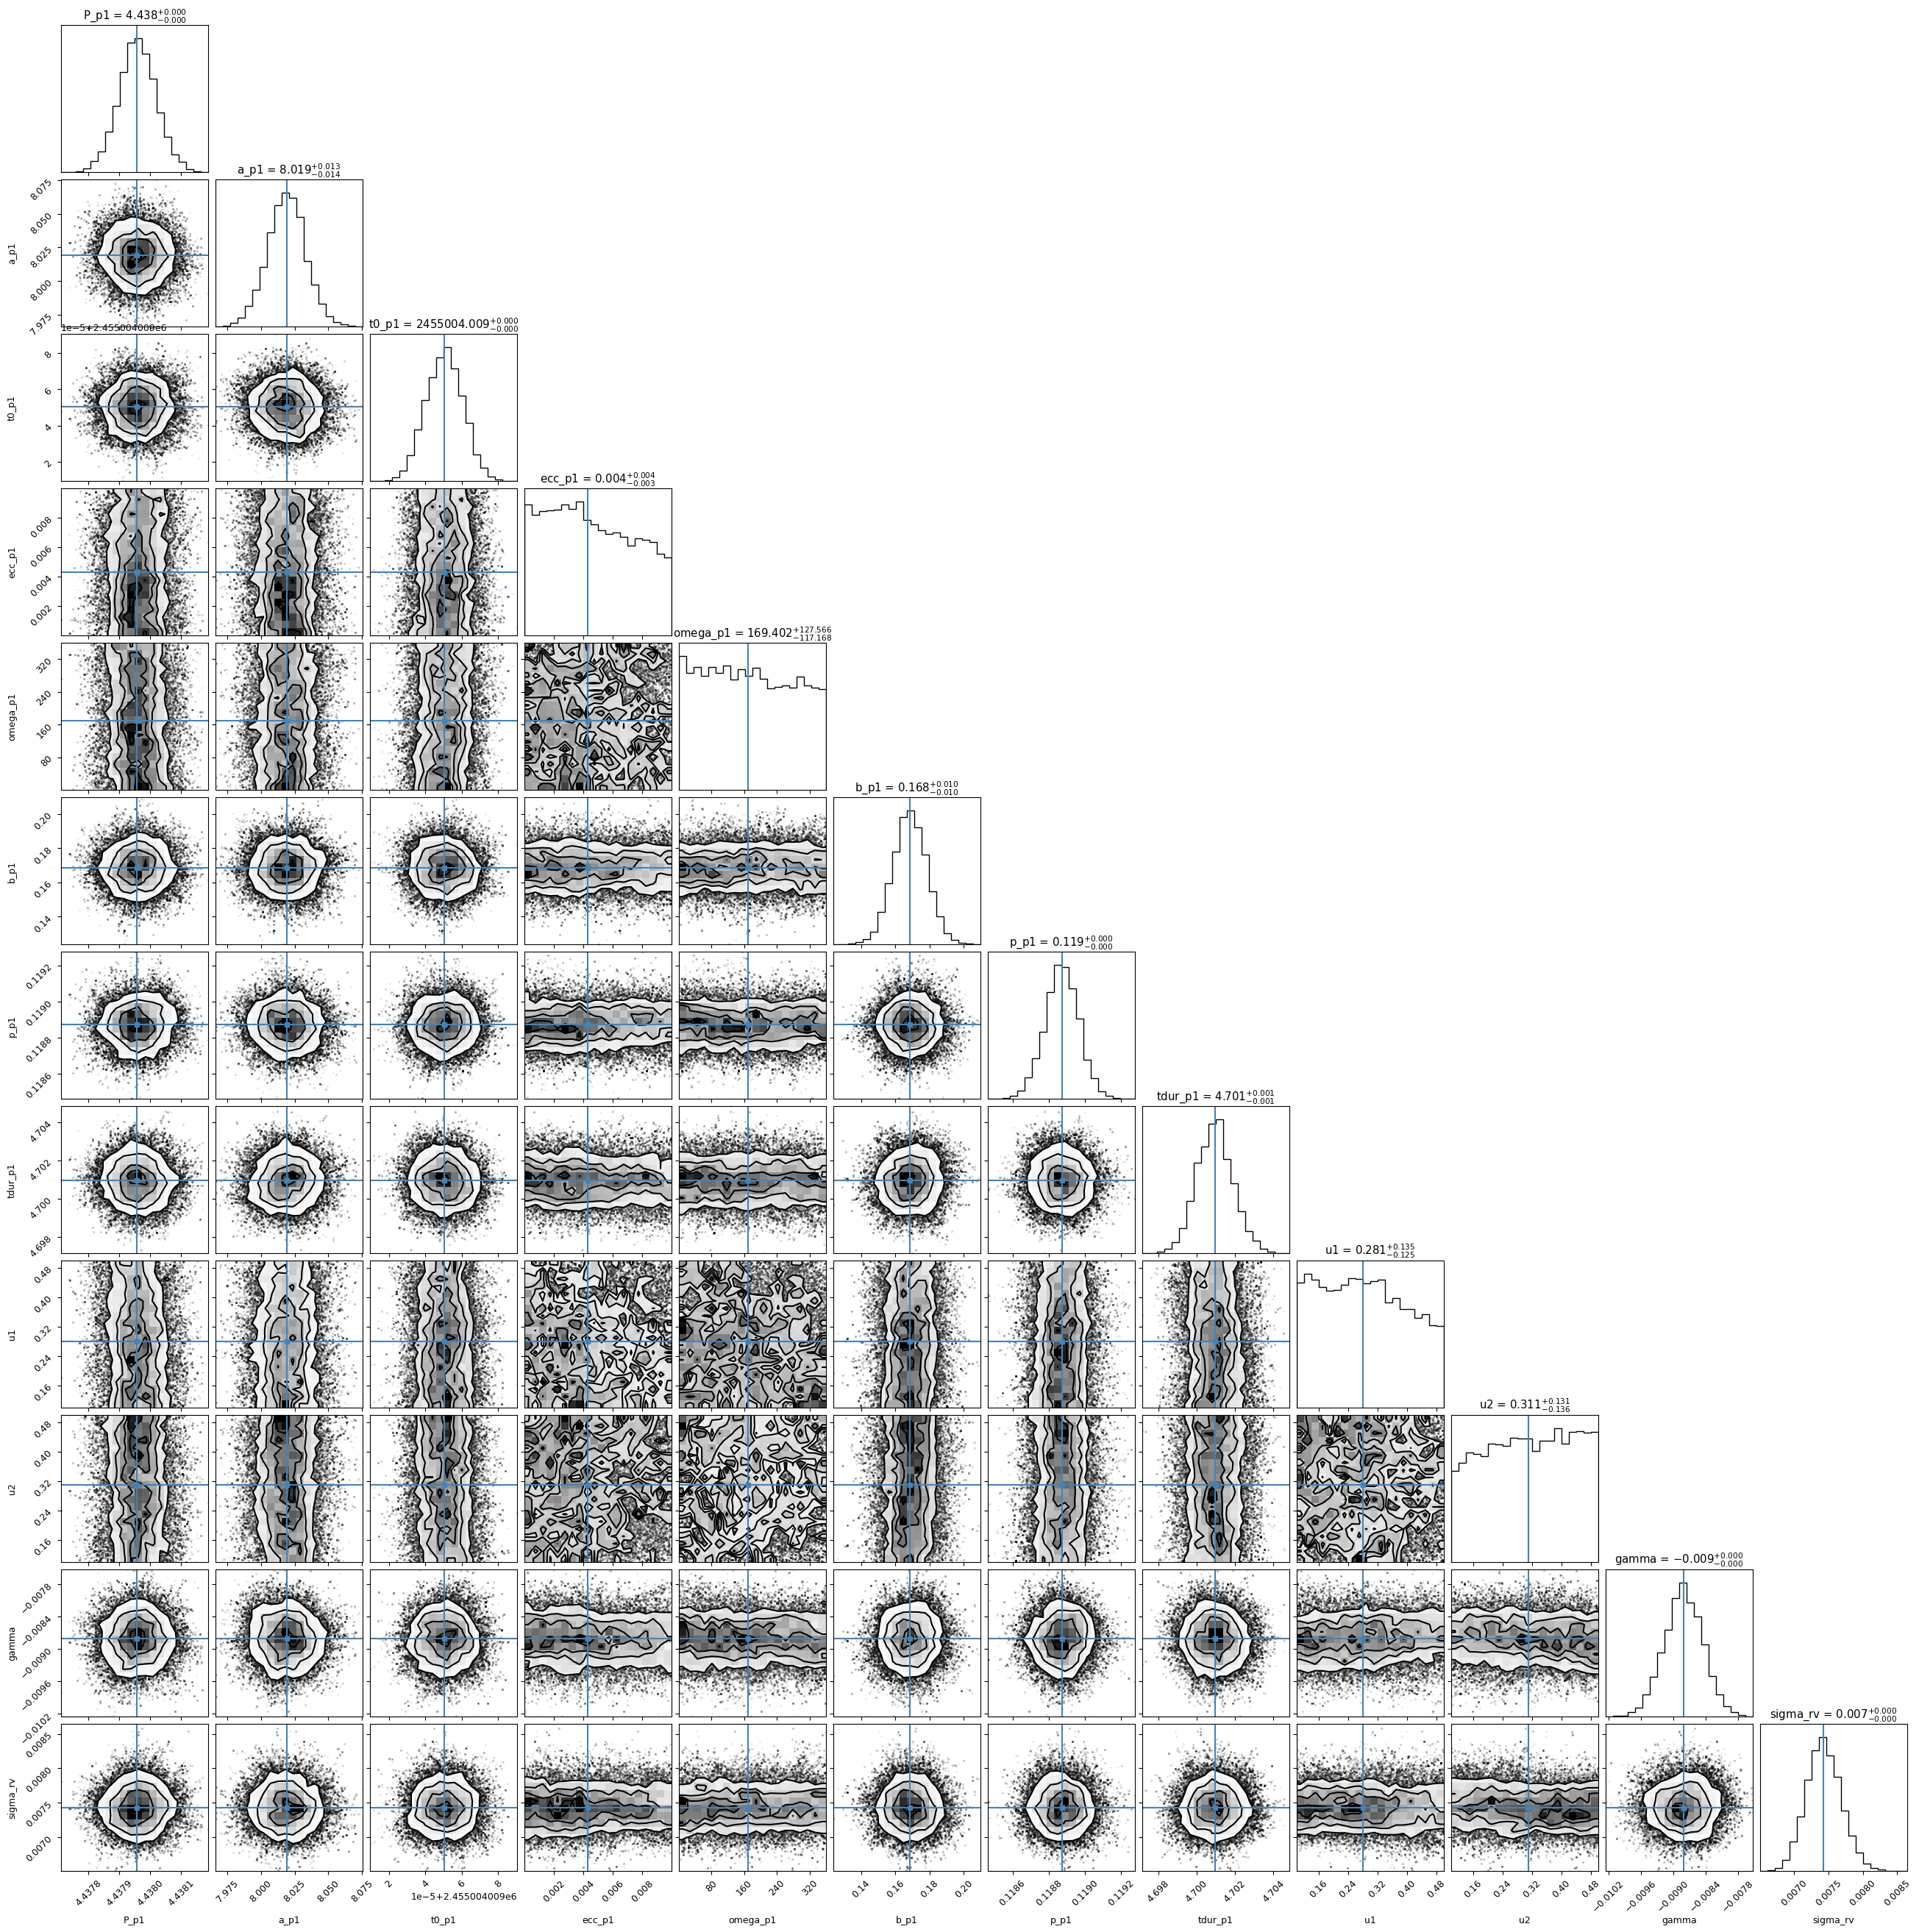

In [16]:
#We again plot the Corner plot but this time with the Truths included to compare them with the values we have obtained from MCMC.
import corner
pv_50 = np.percentile(flatchain,[50],axis=0)[0]
corner.corner(df_post.values,truths=pv_50,
       show_titles=True,labels=list(df_post.columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

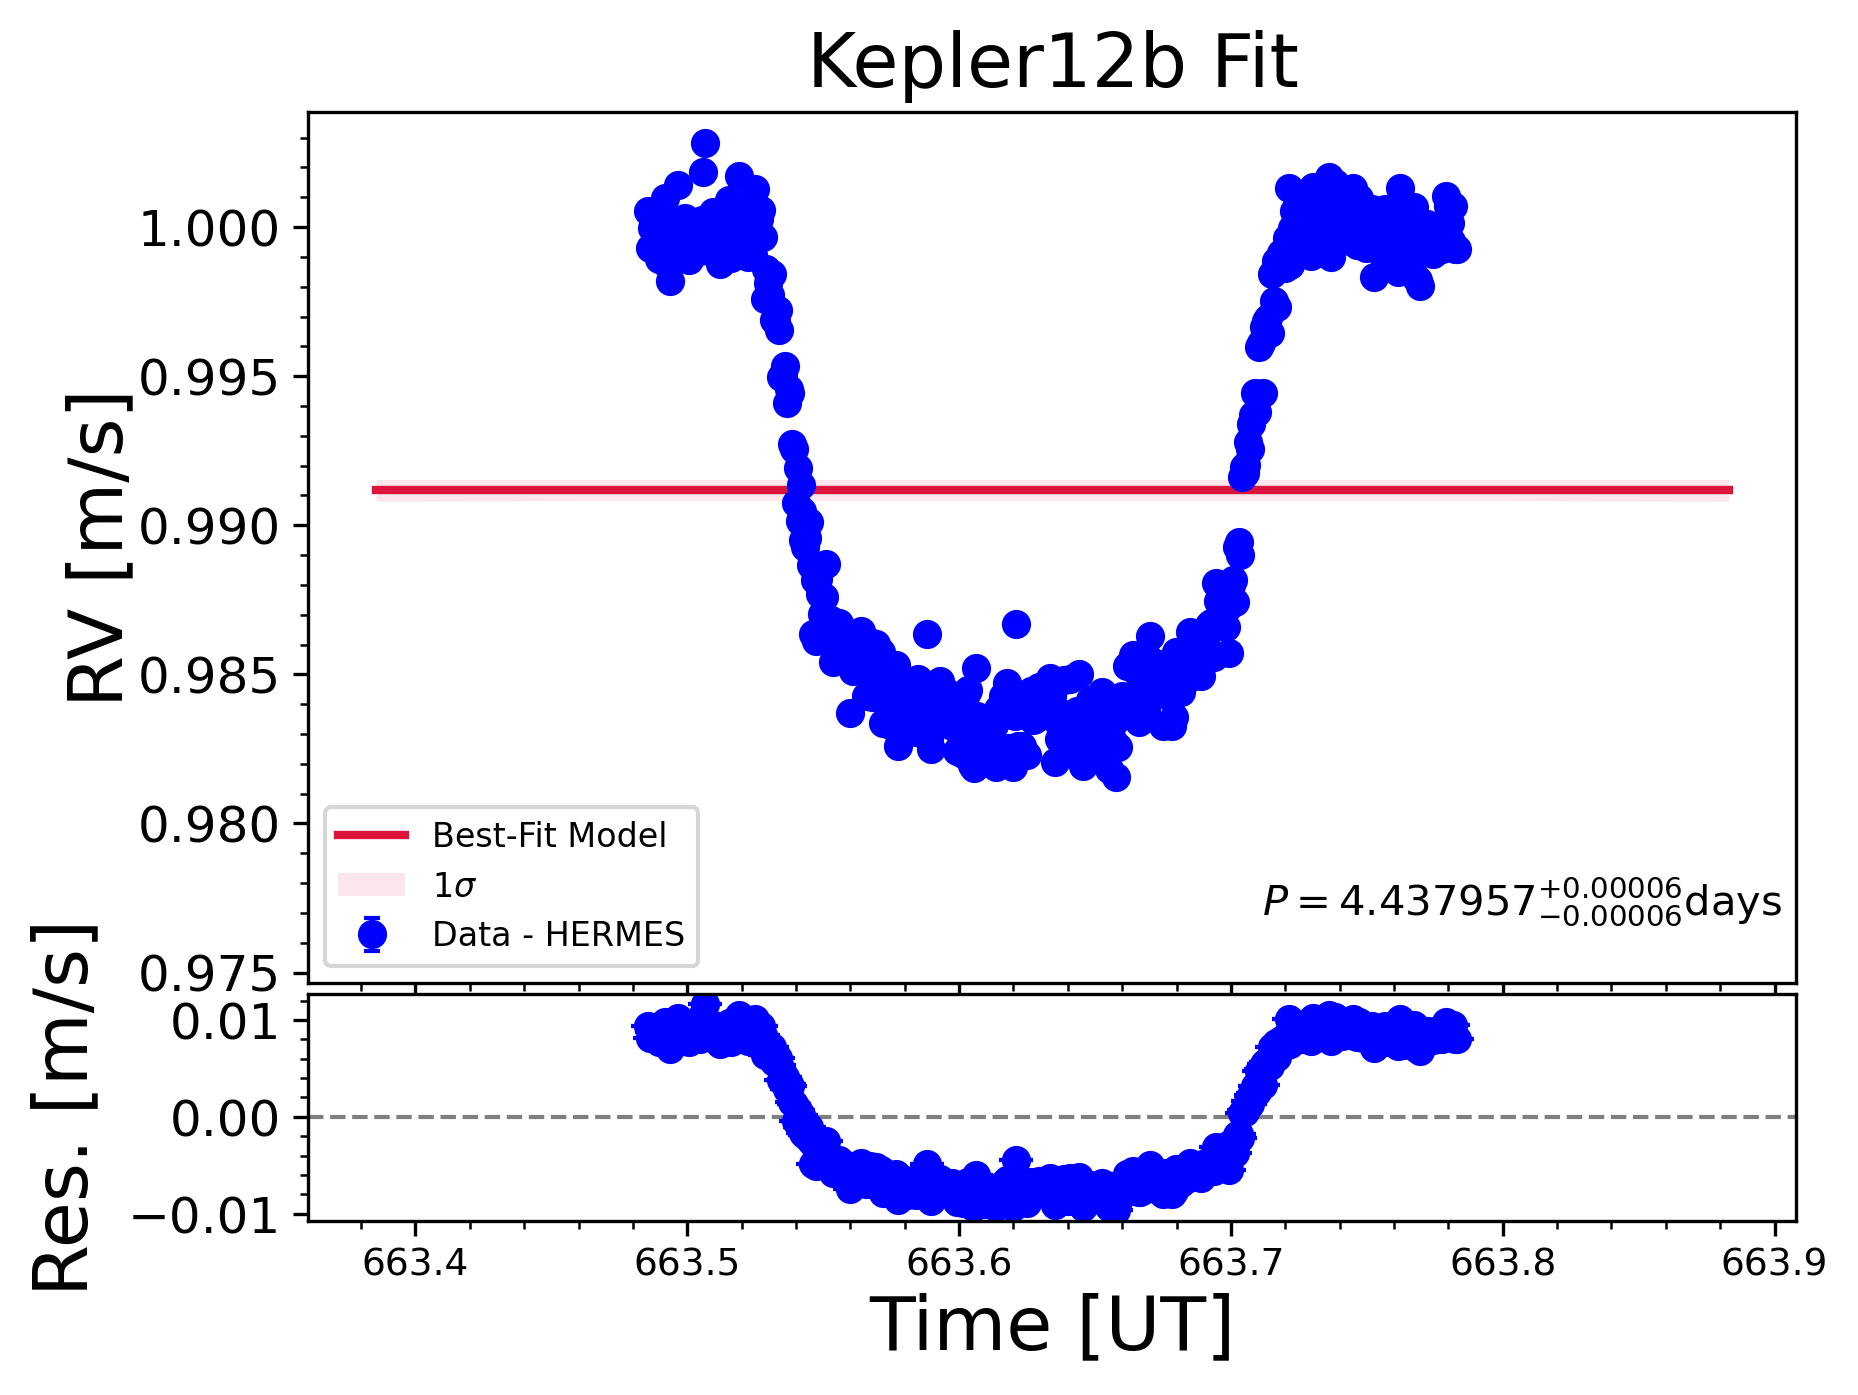

In [17]:
#We import astropy.time to convert Julian Dates into Datetimes i.e. the DD-MM-YYYY Format.
import astropy.time

#We define a function that turns Julian Dates into Datetime format.
def jd2datetime(times):
    return times
    #return np.array([astropy.time.Time(time,format="jd",scale="utc").datetime for time in times])

#We define the Title, Number of Models and the Shade color.
TITLE = 'Kepler12b Fit'
NUMMODELS = 5000
shadecolor="black"

###################
#We define the times using the JD Times from the first and second dataset.
#Note that we define 500 time points.
times1 = np.linspace(TF.lpf.data['x'][0]-0.05,TF.lpf.data['x'][-1]+0.05,500)

#We define the 50th Percentile i.e. the Median by using the Flatchain we defined.
#The "[0]" is to get the percentiles out of the array and turn it into a list.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#We define times for the model/fit this time, using the minimum and maximum times.
#Note that we define 300 time points for the fit.
t1_mod = np.linspace(times1.min()-0.05,times1.max()+0.05,300)

#Our goal is to get the Residuals i.e. Data - Model.
#For that first we compute the Radial Velocities for both instruments using 50th percentiles i.e. the Model.
rv_501 = TF.lpf.compute_total_model(pv_50,t1_mod)

#Then we get the Radial Velocities for both instruments using the datafiles we have i.e. Data.
rv_50_obs1 = TF.lpf.compute_total_model(pv_50,TF.lpf.data['x'])

#We calculate the residuals.
res1 = TF.lpf.data['y'] - rv_50_obs1

#We define the Figure and the Axes.
#Note that we have two rows with one of them showing the RV and the other one showing the Residuals.
fig, (ax,bx) = plt.subplots(dpi=300,nrows=2,gridspec_kw={'height_ratios': [5,1.3]},sharex=True)

#################
# Plot data
#################
#We first plot the Best-Fit Model.
#For that we first define a label.
label = r'Best-Fit Model'

#Then we also add the values of Period and Eccentricity into our label.
#Note that we are using "df_medvals" we found after MCMC.
#Note that we can also add Planet Mass and Inclination by removing "#" from the lines below.
lab = '$P=${}'.format(df_medvals[df_medvals.Labels=='P_p1']['values'].values[0])+'days\n'
#lab += r'$M_p=${}$M_E$'.format(earth_mass)+'\n'
#lab += r'$e=${}'.format(df_medvals[df_medvals.Labels=='ecc_p1']['values'].values[0])+'\n'
#lab += r'$K=${}$m/s$'.format(df_medvals[df_medvals.Labels=='K_p1']['values'].values[0])+'\n'

#We define the marker color to be black for errorbars.
markercolor="blue"

#We define the errorbars & datapoints.
#Note that we put times into the jd2datetime function so that the dates turn from JD to Datetime.
ax.errorbar(jd2datetime(TF.lpf.data['x']),TF.lpf.data['y'],TF.lpf.data['error'],
            marker='o',elinewidth=1,capsize=2,lw=0,mew=1,color=markercolor,markersize=6,label='Data - HERMES')

#We finally also plot our model as follows.
ax.plot(jd2datetime(t1_mod),rv_501,color="crimson",label=label,lw=2.,zorder=-10)

#Now we work on the second Row for the Resiudal graph.
#We also need to plot the residuals with the error bars included.

#For that we define the errorbars & datapoints for the first dataset from first instrument.
bx.errorbar(jd2datetime(TF.lpf.data['x']),res1,TF.lpf.data['error'],
            marker='o',elinewidth=1,capsize=4,lw=0,mew=1,color=markercolor,markersize=6)

#We add the values of our Parameters to the Bottom-Right of our first Graph i.e. RV Graph.
ax.text(0.99,0.01,lab,va='bottom',ha='right',fontsize=10,transform=ax.transAxes)

#We define a list to sample from our model, which we will use for Sigma Errors of our Fit.
mmodel1 = []
for i in range(NUMMODELS):
    #if i%100 == 0: print("Sampling, i=",i)
    idx = np.random.randint(0, flatchain.shape[0])
    m1 = TF.lpf.compute_total_model(flatchain[idx],times=t1_mod)
    mmodel1.append(m1)
mmodel1 = np.array(mmodel1)

#We then show the 1-Sigma Error of our fit as follows.
#There are also options for 2-Sigma and 3-Sigma Errors, commented below.
ax.fill_between(jd2datetime(t1_mod),np.quantile(mmodel1,0.16,axis=0),np.quantile(mmodel1,0.84,axis=0),
                alpha=0.1,color='crimson',lw=0,label='1$\sigma$',zorder=-1)

#We show define the legend for the first row i.e. the RV Graph.
ax.legend(loc='lower left',fontsize=8)

#We define the x-axis and y-axis labels for the second row i.e. the Residuals Graph.
bx.set_xlabel('Time [UT]',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We also define the x-axis of the first row i.e. the RV Graph.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)

#We then define the x limit by using ax.get_xlim()
xlim = ax.get_xlim()

#Using the x limits we define the new xlim to be the first and second element of the xlim array.
ax.set_xlim(xlim[0],xlim[-1])

#We define extra times to plot the zero-line for Residuals.
_x = np.linspace(xlim[0],xlim[-1],100)

#We use the extra times we defined to plot the zero-line for residuals.
bx.plot(_x,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We then set a 0.02 horizontal space between the rows. (Tighter than the default setup.)
fig.subplots_adjust(hspace=0.02)

for xx in [ax,bx]:
    utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis='x',labelsize=9)
ax.set_title(TITLE,fontsize=18)#,y=1.05)

ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-(ylim[-1]-ylim[0])/4, ylim[-1])

#plt.savefig("toi_2431.png", dpi = 500)
plt.show();

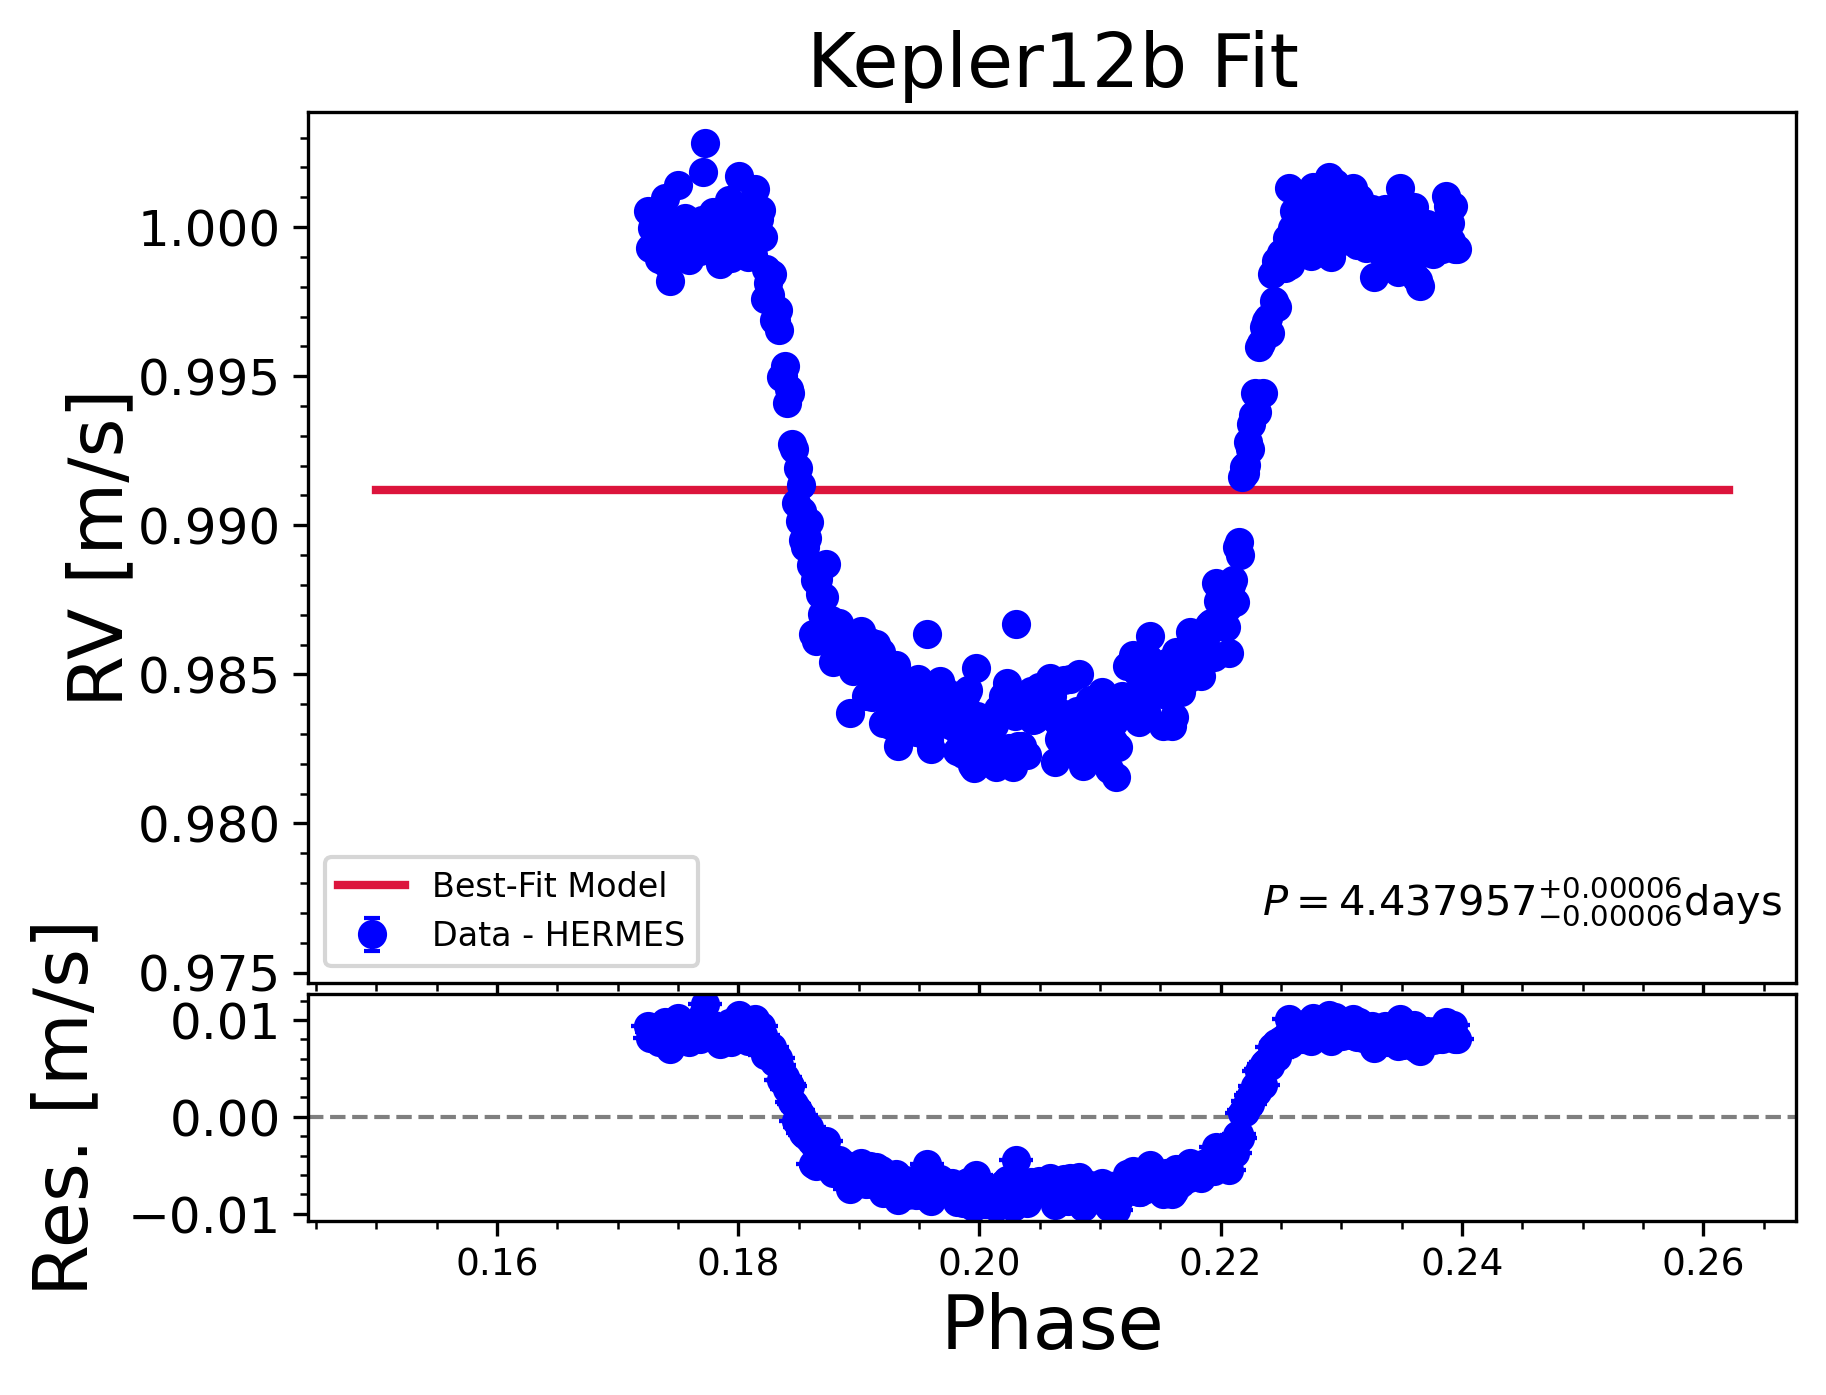

In [18]:
#We get the P and T0 values from the MCMC results.
P = df_medvals["medvals"][df_medvals["Labels"] == "P_p1"].values[0]
T_0 = df_medvals["medvals"][df_medvals["Labels"] == "t0_p1"].values[0]

#We then define a function to convert observation times to the Orbital Phase.
def time_to_phase(times, P, T_0):
    """Takes the Observation Times, Period and the T0. Returns the orbital 
    phases for given Observation Times.
    
    Input:
    ----------------------------------------------------------------------------
    times: Array of observation times (Julian Dates)
    P: Orbital period in days
    T_0: Reference time (epoch or time of periastron) in Julian Date
    
    Output:
    ----------------------------------------------------------------------------
    ((times - T_0) % P) / P: Orbital Phases
    
    """
    
    #Normalize time to phase in the range [0, 1]
    return ((times - T_0) % P) / P

#We convert the observation times from our data to the orbital phases.
phase1 = time_to_phase(TF.lpf.data['x'], P, T_0)

#We also convert the times for the model/fit to the orbital phases.
phase_model = time_to_phase(t1_mod, P, T_0)

#Now we define a figure again for our Phase Curve & Residuals.
fig, (ax, bx) = plt.subplots(dpi=300, nrows=2, gridspec_kw={'height_ratios': [5, 1.3]}, sharex=True)

#################
# Plot data
#################

#We first sort our data according to the Phase values we have.
sorted_indices = np.argsort(phase_model)
phase_model_sorted = phase_model[sorted_indices]
rv_501_sorted = rv_501[sorted_indices]

#Then we plot the fit as follows.
label = r'Best-Fit Model'
ax.plot(phase_model_sorted, rv_501_sorted, color="crimson", label=label, lw=2., zorder=-10)

#We then plot our data around the fit as follows.
ax.errorbar(phase1, TF.lpf.data['y'], TF.lpf.data['error'],
            marker='o', elinewidth=1, capsize=2, lw=0, mew=1, color=markercolor, markersize=6, label='Data - HERMES')

#We plot the residuals on the second row as follows.
res1 = TF.lpf.data['y'] - rv_50_obs1
bx.errorbar(phase1, res1, TF.lpf.data['error'],
            marker='o', elinewidth=1, capsize=4, lw=0, mew=1, color=markercolor, markersize=6)

#We add the label for the fit parameters
ax.text(0.99, 0.01, lab, va='bottom', ha='right', fontsize=10, transform=ax.transAxes)

# For plotting the sigma errors (1-sigma range) - Does not work.
# mmodel1 = []
# for i in range(NUMMODELS):
#     idx = np.random.randint(0, flatchain.shape[0])
#     m1 = TF.lpf.compute_total_model(flatchain[idx], times=t1_mod)
#     mmodel1.append(m1)
# mmodel1 = np.array(mmodel1)

# # Plot 1-sigma error range
# ax.fill_between(phase_model, np.quantile(mmodel1, 0.16, axis=0), np.quantile(mmodel1, 0.84, axis=0),
#                 alpha=0.1, color='crimson', lw=0, label='1$\sigma$', zorder=-1)

#We add the legend and the labels.
ax.legend(loc='lower left', fontsize=8)
ax.set_ylabel('RV [m/s]', labelpad=0, fontsize=18)
bx.set_xlabel('Phase', labelpad=2, fontsize=18)
bx.set_ylabel('Res. [m/s]', labelpad=6, fontsize=18)

#We show define the legend for the first row i.e. the RV Graph.
ax.legend(loc='lower left',fontsize=8)

#We define the x-axis and y-axis labels for the second row i.e. the Residuals Graph.
bx.set_xlabel('Phase',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We also define the x-axis of the first row i.e. the RV Graph.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)

#We then define the x limit by using ax.get_xlim()
xlim = ax.get_xlim()

#Using the x limits we define the new xlim to be the first and second element of the xlim array.
ax.set_xlim(xlim[0],xlim[1])
ax.set_ylim()

#We define extra times to plot the zero-line for Residuals.
_x = np.linspace(xlim[0],xlim[-1],100)

#We use the extra times we defined to plot the zero-line for residuals.
bx.plot(_x,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We then set a 0.02 horizontal space between the rows. (Tighter than the default setup.)
fig.subplots_adjust(hspace=0.02)

for xx in [ax,bx]:
    utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis='x',labelsize=9)
ax.set_title(TITLE,fontsize=18)#,y=1.05)

ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-(ylim[-1]-ylim[0])/4, ylim[-1])

plt.show();